In [1]:
import rioxarray as rxr
from config import DATA_DOWNLOAD_URL
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
import geopandas
import numpy as np
import json

In [2]:
france = geopandas.read_file("data/geojsonfrance_corse_20.json") #Polygons for france dep

In [3]:
res = []
for _, row in france.iterrows(): #loop throught each dep
    dep = france[france["nom"] == row["nom"]] #stay a dataframe for further use
    with rasterio.open(f"{DATA_DOWNLOAD_URL}/AWC_eu23.tif") as src: #open tif dataset
        fill_value = np.float32(src.meta["nodata"]) #get fill_value data
        crs = src.crs #get CRS string
        dep_crs = dep.to_crs(crs) #change dep polygons CRS to CRS of the tif data 
        dep_geom = dep_crs.geometry.values #get new polygons values
        out_image, out_transform = mask(src, dep_geom, crop=True) #mask tif data with our polygon (our departement)
        out_image[out_image == fill_value] = np.nan #replace fill_values with nan 
        res.append({"nom": row["nom"], "awc": float(np.nanmean(out_image))}) #make a dict with mean values for this departement (ignoring nan values)

In [4]:
with open(f"{DATA_DOWNLOAD_URL}/AWC.json", "w") as outfile: #make a json file with output data
    outfile.write(json.dumps(res))

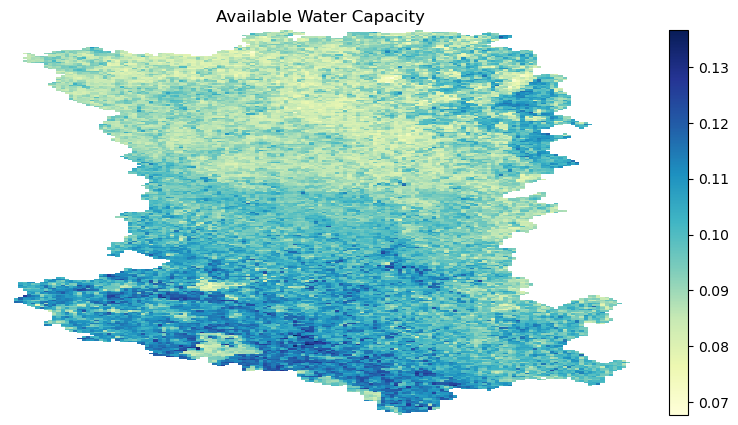

In [6]:
data = rxr.open_rasterio("data/deuxSevres_only.tif")
f, ax = plt.subplots(figsize=(10, 5))
data.plot(cmap="YlGnBu")
ax.set(title="Available Water Capacity")
ax.set_axis_off()
plt.show()